#Análise Exploratória e Previsão de Arremessos da NBA

#Objetivo
    Este projeto visa primeiramente, realizar uma análise exploratória dos dados obtidos das últimas 6 temporadas regulares da NBA (2015-16 a 2020-21) e treinar diferentes modelos de machine learning com o intuito de prever se um arremesso é bem-sucedido ou não.


#Conjunto de Dados
    Os dados foram obtidos através da API da NBA, o script 'get_players_shot_charts.ipynb' criado e a planilha com os ID's dos jogadores pode ser encontrados em:
    
    - (https://github.com/ArthurPatricio/Analise_Exploratoria_e_Previsao_de_Arremessos_da_NBA)

    Os conjuntos de dados foram salvos por temporada em arquivos .xlsx (Ex: 'nba_shots_2020-21')


#Linguagem, Bibliotecas e Pacotes
    O trabalho foi feito todo em Python 3. Abaixo, segue a listagem de todas bibliotecas e pacotes utilizados:


In [ ]:
#Import Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
from pandas_profiling import ProfileReport
import plotly.express as px
import matplotlib as mpl
import time
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [ ]:
# Import Libs

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# Leitura dos Dados
    As 6 planilhas foram importandas e inseridas em Dataframes utilizando a biblioteca pandas.

In [ ]:
#Read NBA Shots excel files

nba_shots_2020_21 = pd.read_excel('nba_shots_2020-21.xlsx', engine='openpyxl')
nba_shots_2019_20 = pd.read_excel('nba_shots_2019-20.xlsx', engine='openpyxl')
nba_shots_2018_19 = pd.read_excel('nba_shots_2018-19.xlsx', engine='openpyxl')
nba_shots_2017_18 = pd.read_excel('nba_shots_2017-18.xlsx', engine='openpyxl')
nba_shots_2016_17 = pd.read_excel('nba_shots_2016-17.xlsx', engine='openpyxl')
nba_shots_2015_16 = pd.read_excel('nba_shots_2015-16.xlsx', engine='openpyxl')

Cada Dataframe tem a coluna "Unnamed: 0" retirada e a coluna "SEASON_ID" adicionada sendo inserida a respectiva temporada do Dataframe em questão.

In [ ]:
#Drop "Unnamed: 0" column, Add "SEASON_ID" column in nba_shots_2020_21

nba_shots_2020_21.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_shots_2020_21['SEASON_ID'] = '2020-21'
nba_shots_2020_21.head()

In [ ]:
#Drop "Unnamed: 0" column, Add "SEASON_ID" column in nba_shots_2019_20

nba_shots_2019_20.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_shots_2019_20['SEASON_ID'] = '2019-20'
nba_shots_2019_20.head()

In [ ]:
#Drop "Unnamed: 0" column, Add "SEASON_ID" column in nba_shots_2018_19

nba_shots_2018_19.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_shots_2018_19['SEASON_ID'] = '2018-19'
nba_shots_2018_19.head()

In [ ]:
#Drop "Unnamed: 0" column, Add "SEASON_ID" column in nba_shots_2017_18

nba_shots_2017_18.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_shots_2017_18['SEASON_ID'] = '2017-18'
nba_shots_2017_18.head()

In [ ]:
#Drop "Unnamed: 0" column, Add "SEASON_ID" column in nba_shots_2016_17

nba_shots_2016_17.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_shots_2016_17['SEASON_ID'] = '2016-17'
nba_shots_2016_17.head()

In [ ]:
#Drop "Unnamed: 0" column, Add "SEASON_ID" column in nba_shots_2015_16

nba_shots_2015_16.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_shots_2015_16['SEASON_ID'] = '2015-16'
nba_shots_2015_16.head()

In [ ]:
#Create nba_shots as a concatenation of the 3 Dataframes from each reagular season

nba_shots = pd.concat([nba_shots_2020_21, nba_shots_2019_20, nba_shots_2018_19, nba_shots_2017_18, nba_shots_2016_17, nba_shots_2015_16], sort=False)

nba_shots.head()

# Análise Inicial de nba_shots

In [ ]:
#Get nba_shots dataframe shape

nba_shots.shape

In [ ]:
#Get nba_shots dataframe columns

nba_shots.columns

In [ ]:
#Get nba_shots dataframe describe

nba_shots.describe()

In [ ]:
#Get nba_shots dataframe info

nba_shots.info()

# Checagem de valores nulos
    nba_shots não possui nenhum valor faltante.

    Foi utulizado a biblioteca missingno para realizar a checagem.

In [ ]:
#Check for messing values in the nba_shots dataframe

msno.matrix(nba_shots)

# Relatório Pandas Profile

    Foi gerado o 'Pandas Profile Report' que oferece uma análise extensa do conjunto de dados que está sendo abordado.

In [ ]:
#Generate and export as a .html file the Pandas Profile Report of the nba_shots dataframe

profile_shots = ProfileReport(nba_shots, title ='nba_shots')
profile_shots.to_file("nba_shots.html")

In [ ]:
#Show Profile Report in this notebook

profile_shots.to_notebook_iframe()

#Função para desenhar a quadra
    A função 'create_court' abaixo foi obtida do seguinte artigo: 
    
    - (https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d)

    Esta função cria desenha uma quadra de basquete nas proporções da NBA utilizando matplotlib.

In [ ]:
# Function to draw basketball court

def create_court(ax, color):
    
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

    # General plot parameters
    #mpl.rcParams['font.family'] = 'Avenir'
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['axes.linewidth'] = 2
    
    return ax


# Análise Exploratória


# 1.Arremessos por Jogador
    De ínicio foram plotados todos os arremessos tentados na temporada 20-21 de 3 atletas da liga (James Harden, Stephen Curry e Nikola Jokic). 

In [ ]:
# JAMES HARDEN 2020-21 REGULAR SEASON SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Shots Scatter Plots
ax.scatter(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1) & (nba_shots['PLAYER_NAME'] == 'James Harden')]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1) & (nba_shots['PLAYER_NAME'] == 'James Harden')]['LOC_Y'] +60, marker = "o", color = "Green")

ax.scatter(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==0) & (nba_shots['PLAYER_NAME'] == 'James Harden')]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==0) & (nba_shots['PLAYER_NAME'] == 'James Harden')]['LOC_Y'] +60, marker = "x", color = "Red")

plt.title('JAMES HARDEN 2020-21 REGULAR SEASON SHOTS', fontsize = 20)
plt.show()

In [ ]:
# SEPHEN CURRY 2020-21 REGULAR SEASON SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.scatter(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1) & (nba_shots['PLAYER_NAME'] == 'Stephen Curry')]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1) & (nba_shots['PLAYER_NAME'] == 'Stephen Curry')]['LOC_Y'] +60, marker = "o", color = "Green")

ax.scatter(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==0) & (nba_shots['PLAYER_NAME'] == 'Stephen Curry')]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==0) & (nba_shots['PLAYER_NAME'] == 'Stephen Curry')]['LOC_Y'] +60, marker = "x", color = "Red")

plt.title('STEPHEN CURRY 2020-21 REGULAR SEASON SHOTS', fontsize = 20)
plt.show()

In [ ]:
# NIKOLA JOKIC 2020-21 REGULAR SEASON SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.scatter(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1) & (nba_shots['PLAYER_NAME'] == 'Nikola Jokic')]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1) & (nba_shots['PLAYER_NAME'] == 'Nikola Jokic')]['LOC_Y'] +60, marker = "o", color = "Green")

ax.scatter(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==0) & (nba_shots['PLAYER_NAME'] == 'Nikola Jokic')]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==0) & (nba_shots['PLAYER_NAME'] == 'Nikola Jokic')]['LOC_Y'] +60, marker = "x", color = "Red")

plt.title('NIKOLA JOKIC 2020-21 REGULAR SEASON SHOTS', fontsize = 20)
plt.show()

# 2.Arremessos Acertados por Temporada
    Abaixo temos as plotagens utilizando a função .hexbin da biblioteca matplotlib.
    
    Nessa sequência de gráficos possível notar como o arremesso de 3 pontos se tornou cada vez mais o arremesso* mais popular na liga.

    *Arremessos não incluem ações ofensivas como bandejas e enterradas, que são feitas próximas da cesta e que continuam proeminentes na liga como pode ser notado em todas as imagens.

In [ ]:
# 2020-21 REGULAR SEASON MADE SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.hexbin(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] +60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Greens')

plt.title('2020-21 REGULAR SEASON MADE SHOTS', fontsize = 20)
plt.show()

In [ ]:
# 2019-20 REGULAR SEASON MADE SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.hexbin(nba_shots[(nba_shots['SEASON_ID'] == '2019-20') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2019-20') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] +60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Greens')

plt.title('2019-20 REGULAR SEASON MADE SHOTS', fontsize = 20)
plt.show()

In [ ]:
# 2018-19 REGULAR SEASON MADE SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.hexbin(nba_shots[(nba_shots['SEASON_ID'] == '2018-19') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2018-19') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] +60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Greens')

plt.title('2018-19 REGULAR SEASON MADE SHOTS', fontsize = 20)
plt.show()

In [ ]:
# 2017-18 REGULAR SEASON MADE SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.hexbin(nba_shots[(nba_shots['SEASON_ID'] == '2017-18') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2017-18') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] +60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Greens')

plt.title('2017-18 REGULAR SEASON MADE SHOTS', fontsize = 20)
plt.show()

In [ ]:
# 2016-17 REGULAR SEASON MADE SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.hexbin(nba_shots[(nba_shots['SEASON_ID'] == '2016-17') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2016-17') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] +60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Greens')

plt.title('2016-17 REGULAR SEASON MADE SHOTS', fontsize = 20)
plt.show()

In [ ]:
# 2015-16 REGULAR SEASON MADE SHOTS

# Create figure and axes
fig = plt.figure(figsize=(10, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
ax.hexbin(nba_shots[(nba_shots['SEASON_ID'] == '2015-16') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2015-16') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] +60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Greens')

plt.title('2015-16 REGULAR SEASON MADE SHOTS', fontsize = 20)
plt.show()

# 3.Outras Visualizações de Arremessos
    Os dados obtidos permitem ainda outras plotagens dos arremessos a seguir são mostradas 3 diferentes formas de enxergar os arremessos de acordo com sua posição em quadra.

Arremessos acertados por região da quadra

    O atributo 'SHOT_ZONE_AREA' oferece as regiões da quadra utilizadas nessa plotagem.


In [ ]:
# 2020-21 REGULAR SEASON SHOTS MADE PER ZONE AREA

# Create figure and axes
fig = plt.figure(figsize=(20, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
sns.scatterplot(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] + 60, hue = nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['SHOT_ZONE_AREA'])

plt.title('2020-21 REGULAR SEASON SHOTS MADE PER ZONE AREA', fontsize = 20)
plt.show()

Arremessos acertados por zonas de distância.

    O atributo 'SHOT_ZONE_RANGE' oferece as zonas por diferentes distâncias utilizadas nessa pltagem.

In [ ]:
# 2020-21 REGULAR SEASON SHOTS MADE PER ZONE RANGE

# Create figure and axes
fig = plt.figure(figsize=(20, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
sns.scatterplot(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] + 60, hue = nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['SHOT_ZONE_RANGE'])

plt.title('2020-21 REGULAR SEASON SHOTS MADE PER ZONE RANGE', fontsize = 20)
plt.show()

Arremessos acertados por regiões da quadra (simplificado).

    O atributo 'SHOT_ZONE_BASIC' oferece regiões da quadra, diferentes das presentes em 'SHOT_ZONE_AREA', utilizadas nessa plotagem.



In [ ]:
# 2020-21 REGULAR SEASON SHOTS MADE PER ZONE AREA (BASIC)

# Create figure and axes
fig = plt.figure(figsize=(20, 9))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'black')

# Plot scatter of shots
sns.scatterplot(nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_X'],
            nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['LOC_Y'] + 60, hue = nba_shots[(nba_shots['SEASON_ID'] == '2020-21') & (nba_shots['SHOT_MADE_FLAG']==1)]['SHOT_ZONE_BASIC'])

plt.title('2020-21 REGULAR SEASON SHOTS MADE PER ZONE AREA (BASIC)', fontsize = 20)
plt.show()

# 4.Distribuição de arrmessos por distância e tipo de Arremesso ( 2 ou 3 pontos)

    O gráfico abaixo apresenta a distribuição dos arremessos das 6 temporadas em análise pela distância em que os arremessos foram feitos.

    Nele é fácil de se notar que a maioria das tentatidas de pontuação ocorre por arremessos de longa distância (atrás da linha de 3 pontos) ou por arremessos, bandejas ou enterradas feitos bem próximos da cesta. Os arremessos de média distância se tornaram algo do passado. 

findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


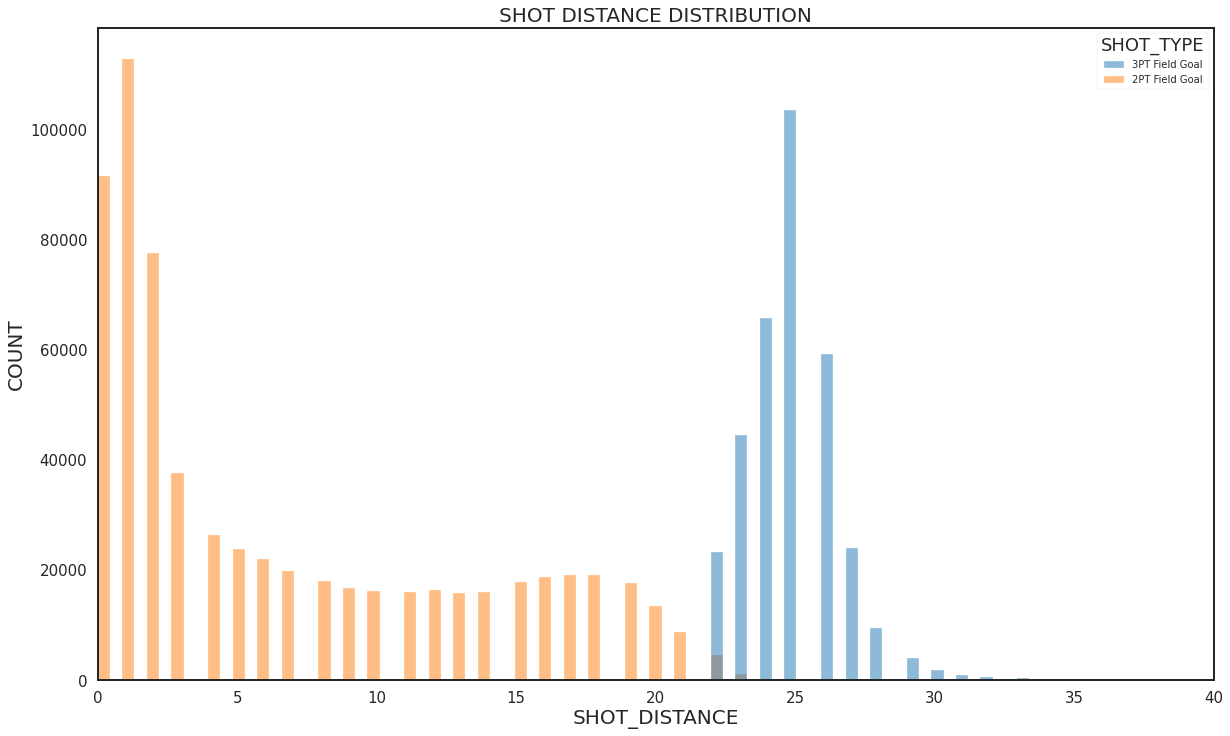

In [35]:
# SHOT DISTANCE DISTRIBUTION PLOT

plt.figure(figsize=(20,12))
fig1 = sns.histplot(data=nba_shots, x='SHOT_DISTANCE', hue = 'SHOT_TYPE')
fig1.set_xlabel('SHOT_DISTANCE', fontsize=20)
fig1.set_ylabel('COUNT', fontsize=20)
fig1.tick_params(labelsize=15)
plt.title('SHOT DISTANCE DISTRIBUTION', fontsize = 20)
plt.xlim(0,40)
plt.show()

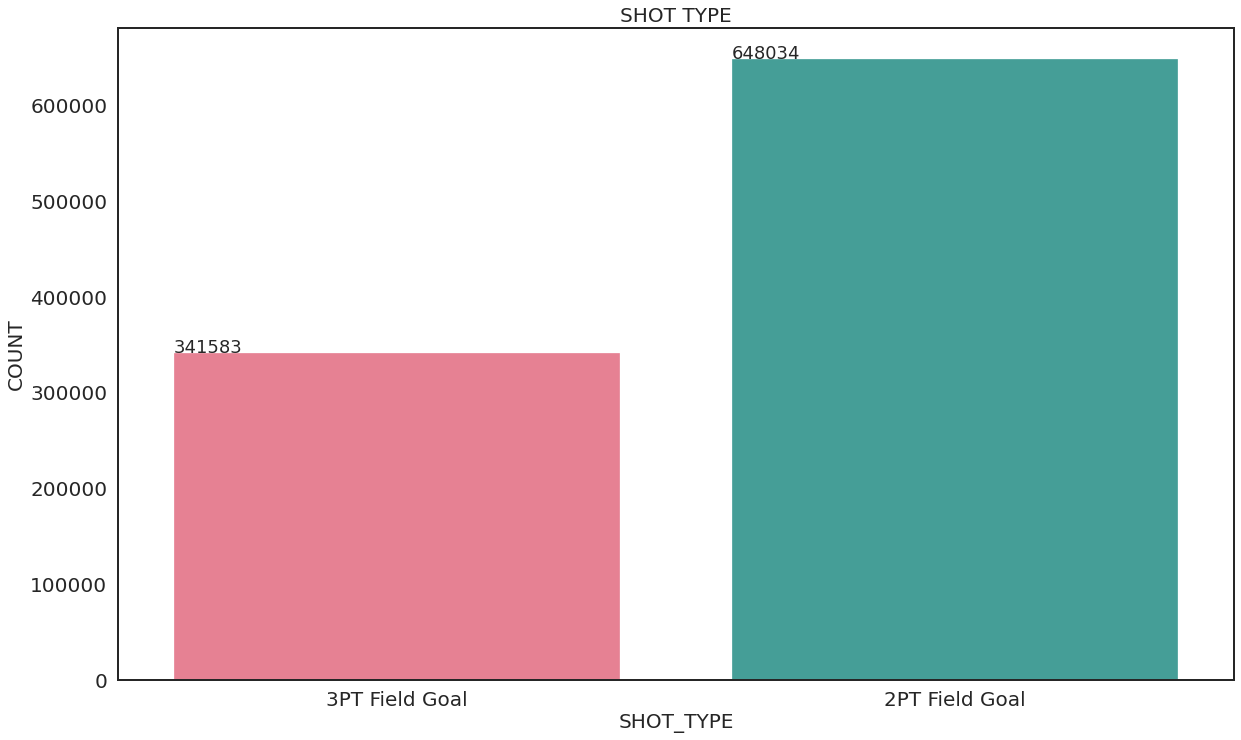

In [36]:
# SHOT TYPE BAR PLOT

plt.figure(figsize=(20,12))
fig2 = sns.countplot(data=nba_shots, x='SHOT_TYPE', palette = 'husl')
fig2.set_xlabel('SHOT_TYPE', fontsize=20)
fig2.set_ylabel('COUNT', fontsize=20)
fig2.tick_params(labelsize=20)
plt.title('SHOT TYPE', fontsize = 20)
for p in fig2.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig2.text(txt_x,txt_y,txt)
plt.show()

In [ ]:
# SHOT TYPE (MADE/MISSED) BAR PLOT

plt.figure(figsize=(20,12))
fig3 = sns.countplot(data=nba_shots, x='SHOT_TYPE', palette = 'husl', hue = 'EVENT_TYPE')
fig3.set_xlabel('SHOT_TYPE', fontsize=20)
fig3.set_ylabel('COUNT', fontsize=20)
fig3.tick_params(labelsize=20)
plt.title('SHOT TYPE', fontsize = 20)
for p in fig3.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig3.text(txt_x,txt_y,txt)
plt.show()

In [ ]:
# SHOT ACTION TYPE BAR PLOT

plt.figure(figsize=(45,12))
fig4 = sns.countplot(data=nba_shots, x='ACTION_TYPE', palette = 'husl') 
fig4.set_xlabel('ACTION_TYPE', fontsize=20)
fig4.set_ylabel('COUNT', fontsize=20)
fig4.tick_params(labelsize=20)
fig4.tick_params(axis = 'x', rotation = 90)
plt.title('SHOT ACTION TYPE', fontsize = 20)
for p in fig4.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig4.text(txt_x,txt_y,txt)
plt.show()

#Create player sub dataset

In [ ]:
# Due to the large amount of the dataset, everything past this point you be done per player. The function below creates a sub dataset from nba_shots with the data form the chosen player. 

def choose_player (player_name):
    player_shots = nba_shots[nba_shots['PLAYER_NAME'] == player_name]
    print(player_shots.head())
    
    # Dimensional Reduction: Columns PLAYER_ID and PLAYER_NAME carry the same type of information, PLAYER_NAME is going to be droped. 
    # The same happens to columns EVENT_TYPE and SHOT_MADE_FLAG, EVENT_TYPE is going to be droped.
    # It also happens for TEAM_ID and TEAM_NAME, TEAM_NAME is going to be droped.

    nba_shots_ml = player_shots.drop(['PLAYER_NAME', 'EVENT_TYPE', 'TEAM_NAME'], axis = 1)
    
    # Apply Dummy Coding to the categorial attributes of the dataset

    categorical_columns = ['GRID_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 
    'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'HTM', 'VTM', 'SEASON_ID']

    for i in categorical_columns:

        nba_shots_ml = pd.get_dummies(nba_shots_ml, columns=[i], drop_first=True)

    #Train/Test split

    X = nba_shots_ml.loc[:, nba_shots_ml.columns != 'SHOT_MADE_FLAG']
    y = nba_shots_ml['SHOT_MADE_FLAG']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size= 0.3, 
                                                        random_state = 100, 
                                                        stratify = y,
                                                        )

    # Check columns with variance equal to zero and drop them

    zero_var_filter = VarianceThreshold()
    X_train = zero_var_filter.fit_transform(X_train)
    X_test = zero_var_filter.transform(X_test)
    print('X_train e X_test possuíam', (zero_var_filter.variances_ == 0).sum(), 'atributo(s) com variância igual a zero')

    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)

    # Normalize the data

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = choose_player('Stephen Curry')

#Create season sub dataset

In [ ]:
# Due to the large amount of the dataset, everything past this point you be done per season. The function below creates a sub dataset from nba_shots with the data form the chosen season. 

def choose_season (season_id):
    season_shots = nba_shots[nba_shots['SEASON_ID'] == season_id]
    print(season_shots.head())
    
    # Dimensional Reduction: Columns PLAYER_ID and PLAYER_NAME carry the same type of information, PLAYER_NAME is going to be droped. 
    # The same happens to columns EVENT_TYPE and SHOT_MADE_FLAG, EVENT_TYPE is going to be droped.
    # It also happens for TEAM_ID and TEAM_NAME, TEAM_NAME is going to be droped.

    nba_shots_ml = season_shots.drop(['PLAYER_NAME', 'EVENT_TYPE', 'TEAM_NAME'], axis = 1)
    
    # Apply Dummy Coding to the categorial attributes of the dataset

    categorical_columns = ['GRID_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 
    'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'HTM', 'VTM', 'SEASON_ID']

    for i in categorical_columns:

        nba_shots_ml = pd.get_dummies(nba_shots_ml, columns=[i], drop_first=True)

    #Train/Test split

    X = nba_shots_ml.loc[:, nba_shots_ml.columns != 'SHOT_MADE_FLAG']
    y = nba_shots_ml['SHOT_MADE_FLAG']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size= 0.2, 
                                                        random_state = 100, 
                                                        #stratify = y
                                                        )

    # Check columns with variance equal to zero and drop them

    zero_var_filter = VarianceThreshold()
    X_train = zero_var_filter.fit_transform(X_train)
    X_test = zero_var_filter.transform(X_test)
    print('X_train e X_test possuíam', (zero_var_filter.variances_ == 0).sum(), 'atributo(s) com variância igual a zero')

    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)

    # Normalize the data

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = choose_season('2020-21')

#SVM

In [ ]:
# Train and predict SVM model

def train_SVM(X_train, y_train):
  model = SVC(random_state=100)
  model.fit(X_train, y_train)
  return model

model_SVM = train_SVM(X_train, y_train)
y_pred_SVM = model_SVM.predict(X_test)

In [ ]:
# Evaluate SVM model

def evaluate_SVM(X_test, y_test):

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_SVM)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_SVM)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_SVM)
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_SVM, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap ="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])

evaluate_SVM(X_test, y_test)

In [ ]:
# Train and predict SVM model with hyper-parameters tuning (GridSearchCV)


tuned_parameters = [{'kernel': ['rbf', 'poly', 'linear'],
                    'gamma': [100, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4],
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
                     
print("Hyperparameter Tuning for accuracy")
print()

model = GridSearchCV(SVC(random_state=100), tuned_parameters, scoring='accuracy')
model.fit(X_train, y_train)

y_pred_SVM_GS = model.predict(X_test)
print(classification_report(y_test, y_pred_SVM_GS))
print()
print("BEST TUNED PARAMETERS", model.best_params_)

In [ ]:
# Evaluate SVM model with hyper-parameters tuning (GridSearchCV)

def evaluate_SVM_GS(y_test, y_pred_SVM_GS):

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_SVM_GS)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_SVM_GS)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_SVM_GS)
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_SVM_GS, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap ="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])

evaluate_SVM_GS(y_test, y_pred_SVM_GS)

#Decision Tree

In [ ]:
# Train and predict Decision Tree model

def train_DT(X_train, y_train):
  model = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 5, random_state=100)
  model.fit(X_train, y_train);
  return model

model_DT = train_DT(X_train, y_train)
y_pred_DT = model_DT.predict(X_test)

In [ ]:
# Plot decision tree

plt.figure(figsize=(20, 10))
tree.plot_tree(model_DT, class_names=["OUT", "IN"], filled=True, rounded=True);

In [ ]:
# Train and predict Decision Tree model with hyper-parameters tuning (GridSearchCV)

tuned_parameters = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
                        'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}]

print("Hyperparameter Tuning for accuracy")
print()

model = GridSearchCV(DecisionTreeClassifier(random_state=100), tuned_parameters, scoring='accuracy')
model.fit(X_train, y_train)

y_pred_DT_GS = model.predict(X_test)
print(classification_report(y_test, y_pred_DT))
print()
print("BEST TUNED PARAMETERS", model.best_params_)

In [ ]:
# Evaluate Decision Tree model with hyper-parameters tuning (GridSearchCV)

def evaluate_DT_GS(y_test, y_pred_DT):  

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_DT)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_DT)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_DT, average='weighted')
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_DT, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap ="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])
  plt.show()

evaluate_DT_GS(y_test, y_pred_DT)

#Random Forest

In [ ]:
# Train and predict Random Forest model

def train_RF(X_train, y_train):
  model = RandomForestClassifier(min_samples_leaf=5, random_state=100)
  model.fit(X_train, y_train);
  return model

model_RF = train_RF(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)

In [ ]:
model_RF.feature_importances_

In [ ]:
# Evaluate Random Forest model

def evaluate_RF(y_test, y_pred_RF):  

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_RF)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_RF)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_RF, average='weighted')
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_RF, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])
  plt.show()

evaluate_RF(y_test, y_pred_RF)

In [ ]:
# Plot the importance of the attributes to the model

importances = model_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_RF.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure(figsize=(20,50))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="g", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# Train and predict Random Forest model with hyper-parameters tuning (GridSearchCV)

tuned_parameters = [{'n_estimators': [20, 50, 100, 150, 200, 300, 400, 500],
                     'max_features': [3,4,8,9,10,11]}]

print("Hyperparameter Tuning for accuracy")
print()

model = GridSearchCV(RandomForestClassifier(n_jobs=50, verbose=1, random_state=100), tuned_parameters, scoring='accuracy')
model.fit(X_train, y_train)

y_pred_RF = model.predict(X_test)
print(classification_report(y_pred, y_test))
print()
print("BEST TUNED PARAMETERS", model_XGB_GS.best_params_)

In [ ]:
# Evaluate Random Forest model with hyper-parameters tuning (GridSearchCV)

def evaluate_RF_GS(y_test, y_pred_RF):  

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_RF)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_RF)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_RF, average='weighted')
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_RF, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])
  plt.show()

evaluate_RF_GS(y_test, y_pred_RF)

#Gradient Boosting Classifier

In [ ]:
# Train and predict Gradient Boosting Classifier

def train_GBC (X_train, y_train):
    model = GradientBoostingClassifier(n_estimators=1,
                                        min_samples_leaf=5,
                                        learning_rate=0.1,
                                        loss='deviance',
                                        subsample=1.0,
                                        criterion='fiedman_mse',
                                        min_samples_split=2,
                                        max_depth=8,
                                        random_state=100
                                        )
    model.fit(X_train, y_train)
    return model

model_GBC = train_GBC(X_train, y_train)
y_pred_GBC = model_GBC.predict(X_test)

In [ ]:
# Evaluate Gradient Boosting Classifier model

def evaluate_GBC(y_test, y_pred_GBC):

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_GBC)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_GBC)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_GBC)
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_GBC, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap ="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])

evaluate_GBC(X_test, y_test)

#XGBOOST

In [ ]:
# Train and predict XGBOOST model

def train_XGB (X_train, y_train):
    model = xgb.XGBClassifier(n_estimators=2000, 
                              objective="reg:logistic", 
                              booster='gbtree', 
                              alpha=10, 
                              max_depth=8,
                              gamma=1e-2,
                              colsample_bytree=0.8,
                              random_state=100)
    model.fit(X_train, y_train)
    return model

model_XGB = train_XGB(X_train, y_train)
y_pred_XGB = model_XGB.predict(X_test)

In [ ]:
# Evaluate XGBOOST model

def evaluate_XGB(X_test, y_test):

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_XGB)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_XGB)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_XGB)
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_XGB, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap ="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])

evaluate_XGB(X_test, y_test)

In [ ]:
# Plot the importance of the attributes to the model

xgb.plot_importance(model_XGB)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


In [ ]:
# Train and predict XGBOOST model with hyper-parameters tuning (GridSearchCV)

tuned_parameters = {
                    #'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
                    #'max_depth': [8,9,10,11,12,13], 
                    #'alpha': [5,6,7,8,9,10,11,12,13,14,15,17,18,19,20],
                    #'lambda': [5,6,7,8,9,10,11,12,13,14,15,17,18,19,20]
                    #'min_child_weight': [1, 5, 10],
                    #'colsample_bytree': [0.6, 0.8, 1.0]
                    #'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                    #'n_estimators': [50, 100, 200, 300, 400, 500, 1000]
                    }

print('Hyperparameter Tuning for accuracy')

model_XGB_GS = GridSearchCV(xgb.XGBClassifier(
                                            objective='reg:squarederror',
                                            n_estimators=100,
                                            use_label_encoder=False,
                                            random_state=100,
                                            alpha=10,
                                            max_depth=8,
                                            gamma=1e-3,
                                            learning_rate=0.3,
                                            min_child_weight=0.0001,
                                            #lambda=7,
                                            ), 
                                              tuned_parameters, )
model_XGB_GS.fit(X_train, y_train)

y_pred_XGB_GS = model_XGB_GS.predict(X_test)
print(classification_report(y_test, y_pred_XGB_GS))
print()
print("BEST TUNED PARAMETERS", model_XGB_GS.best_params_)
                    

In [ ]:
# Evaluate XGBOOST model with hyper-parameters tuning (GridSearchCV)

def evaluate_XGB_CV(y_test, y_pred_XGB_GS):

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred_XGB_GS)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred_XGB_GS)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred_XGB_GS)
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred_XGB_GS, y_test)

  plt.figure(figsize=(20,12))
  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f", cmap ="YlGnBu")
  plt.xlabel('REAL')
  plt.ylabel('PRED')
  plt.title('CONFUSION MATRIX')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['OUT', 'IN']) 
  ax.yaxis.set_ticklabels(['OUT', 'IN'])

evaluate_XGB_CV(y_test, y_pred_XGB_GS)